# Project Summary

Provide a clear explanation of:
  1. What this project is about
     - Clearly state the ML type (supervised/unsupervised)
  2. The goal of the project
     - E.g. why it’s important, what goal you want to achieve, or want to learn.

# Data Summary

In [126]:
# Load python libraries that will be used for the analysis
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

### Data Source

Data is extracted from the BBC News Classification competition. CSV files were downloaded directly from Kaggle and saved locally.

> Kaggle. (n.d.). BBC News Classification [Data set]. Kaggle. Retrieved September 24, 2025, from https://www.kaggle.com/competitions/learn-ai-bbc/data

### Load Datasets

In [ ]:
# Load training and test data
train_df = pd.read_csv('./BBC News Train.csv')
test_df = pd.read_csv('./BBC News Test.csv')

### Inspect Datasets

In [41]:
# Display first 10 rows of data in the train_df
train_df

ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          business  
...             ...  
1485  entertainment  
1486  entertainment  
1487       business  
1488           tech  
1489           tech  

[1490 rows x 3 columns]

In [42]:
# Check the shape of the train_df dataframe
print(f'train_df shape: Rows = {train_df.shape[0]}, Columns = {train_df.shape[1]}\n')

# Check the  data types of the train_df dataframe
train_df.info()

train_df shape: Rows = 1490, Columns = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [43]:
# Display first 10 rows of data in the test_df
test_df

ArticleId                                               Text
0         1018  qpr keeper day heads for preston queens park r...
1         1319  software watching while you work software that...
2         1138  d arcy injury adds to ireland woe gordon d arc...
3          459  india s reliance family feud heats up the ongo...
4         1020  boro suffer morrison injury blow middlesbrough...
..         ...                                                ...
730       1923  eu to probe alitalia  state aid  the european ...
731        373  u2 to play at grammy awards show irish rock ba...
732       1704  sport betting rules in spotlight a group of mp...
733        206  alfa romeos  to get gm engines  fiat is to sto...
734        471  citizenship event for 18s touted citizenship c...

[735 rows x 2 columns]

In [44]:
# Check the shape of the test_df dataframe
print(f'test_df shape: Rows = {test_df.shape[0]}, Columns = {test_df.shape[1]}\n')

# Check the  data types of the test_df dataframe
test_df.info()

test_df shape: Rows = 735, Columns = 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


# Data Cleaning

### Check for Missing Data in the Training Set

In [45]:
# Check is any data is missing in train_df
train_df.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

> It appears that no data is missing in the `train_df` dataset

### Check for the Number of Unique Categories in the Training Set 

In [46]:
# Display the number of unique categories in the `Category` column
unique_topics = train_df['Category'].unique()
print(f'Unique Categories:\n {[cat for cat in unique_topics]}\n')

Unique Categories:
 ['business', 'tech', 'politics', 'sport', 'entertainment']



### Check for the Duplicates in the Training Set 

In [47]:
# Check for duplicate values in the `Text` columns in train_df
print(f'Count of duplicated values in the `Text` column of train_df = {train_df['Text'].duplicated().sum()}\n')

Count of duplicated values in the `Text` column of train_df = 50



In [48]:
# Create a dataframe of duplicated values in the `Text` column
duplicate_df = train_df[train_df.duplicated(subset=['Text'], keep=False)].sort_values(by='Text')

# Display first 10 rows of data in duplicate_df
duplicate_df

ArticleId                                               Text  \
494        1326  ask jeeves joins web log market ask jeeves has...   
228        1098  ask jeeves joins web log market ask jeeves has...   
1430       1042  aviator  creator  in oscars snub the man who s...   
695         374  aviator  creator  in oscars snub the man who s...   
443        1847  blind student  hears in colour  a blind studen...   
...         ...                                                ...   
1047        789  virus poses as christmas e-mail security firms...   
1409        957  web radio takes spanish rap global spin the ra...   
616         110  web radio takes spanish rap global spin the ra...   
63         2017  what high-definition will do to dvds first it ...   
1439       1111  what high-definition will do to dvds first it ...   

           Category  
494            tech  
228            tech  
1430  entertainment  
695   entertainment  
443            tech  
...             ...  
1047           tech  
1409           tech  
616            tech  
63             tech  
1439           tech  

[100 rows x 3 columns]

> The duplicate values table above indicates there are 50 duplicated values in the `Text` column in `train_df`. The last occurance of each duplicate will be removed to reduce overfitting the model.

In [49]:
# Drop duplicate rows from the train_df dataframe
train_df = train_df.copy().drop_duplicates(subset='Text', keep='first')

# Check the size of train_df after dropping duplicates
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1440 non-null   int64 
 1   Text       1440 non-null   object
 2   Category   1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.0+ KB


### Add Word Count and Character Count Columns to the Training Set

In [51]:
# Add word counts and character counts columns to train_df
train_df.loc[:,'word_count'] = train_df['Text'].str.split().apply(len)
train_df.loc[:,'char_count'] = train_df['Text'].str.len()

# Display first 10 rows of data in train_df
train_df

ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  word_count  char_count  
0          business         301        1866  
1          business         325        2016  
2          business         514        3104  
3              tech         634        3618  
4          business         355        2190  
...             ...         ...         ...  
1485  entertainment         223        1266  
1486  entertainment         558        3111  
1487       business         237        1370  
1488           tech         560        3242  
1489           tech         295        1723  

[1440 rows x 5 columns]

# EDA

### Plot the Number of Articles Per Category for the Training Set

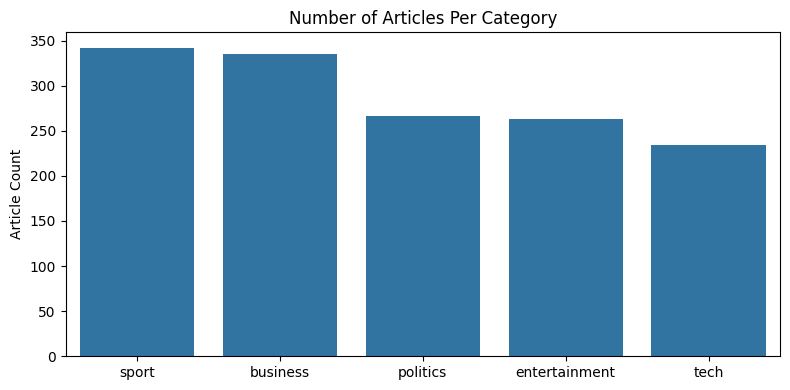

In [52]:
# Plot the number of articles per category in train_df
plt.figure(figsize=(8, 4))
sns.countplot(x='Category', data=train_df, order=train_df['Category'].value_counts().index)
plt.title('Number of Articles Per Category')
plt.ylabel('Article Count')
plt.xlabel(None)
plt.tight_layout()

> The bar chart shows that articles are most often written about sports and business.

### Plot the Median Word Counts for the Training Set

In [53]:
# Calculate the median word_count values for each category
boxplot_medians = train_df[['Category','word_count']].groupby(['Category']).median().sort_values(by='word_count', ascending=False)

# Display the boxplot_medians (sorted in descending order)
boxplot_medians

word_count
Category                 
tech                461.5
politics            445.0
business            304.0
sport               296.5
entertainment       271.0

In [54]:
# Create a boxplot distribution of word counts by category
alt.Chart(train_df).mark_boxplot(
    size=100,
    outliers=False,
    orient='vertical'
).encode(
    y=alt.Y('word_count:Q'),
    x=alt.X('Category:N', title=None, axis=alt.Axis(labelAngle=0)),
    color=alt.Color('Category:N', legend=None)
).properties(
    width=700,
    title=alt.Title('Distribution of Word Counts by Category')
)

alt.Chart(...)

> - The boxplot indicates that articles in the `tech` and `politics` categories are longer because their median word counts are sligthly higher than the median word counts for the `business`, `sport`, and `entertainment` categories.  
> -  This make sense because I can imagine that technical and political articles may be longer and more in depth than the other types of documents.

### Plot the Distribution of Character Counts by Category for the Training Set

In [55]:
# Create a faceted distribution of character counts by category
alt.Chart(train_df).mark_bar().encode(
    x=alt.X('char_count:Q', bin=alt.Bin(maxbins=50), title=None),
    y='count()',
    facet=alt.Facet('Category:N', title='Distribution of Document Character Counts by Category'),
    color=alt.Color('Category:N', legend=None)
).properties(width=150)

alt.Chart(...)

### Extract Word Features Using TF-IDF

Chose TF-IDF based on this guide: https://neptune.ai/blog/vectorization-techniques-in-nlp-guide

TF-IDF (Term Frequency–Inverse Document Frequency) is a way to measure how important a word is in a collection of documents. The TF part counts how often a word appears in a document, while the IDF part down-weights words that appear everywhere (like “the” or “and”). Multiplying them gives higher scores to words that are frequent in one document but rare across the whole corpus, making them useful for distinguishing between texts. In practice, TF-IDF turns raw text into weighted numerical features that machine learning models can use.

In [ ]:
# Train-test split
X_train = train_df['Text'].astype(str)
y_train = train_df['Category']
X_test = test_df['Text'].astype(str)

# Create TF-IDF instance
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=100)

# Create document-term matrix
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Plot the Top Terms by Average TF-IDF

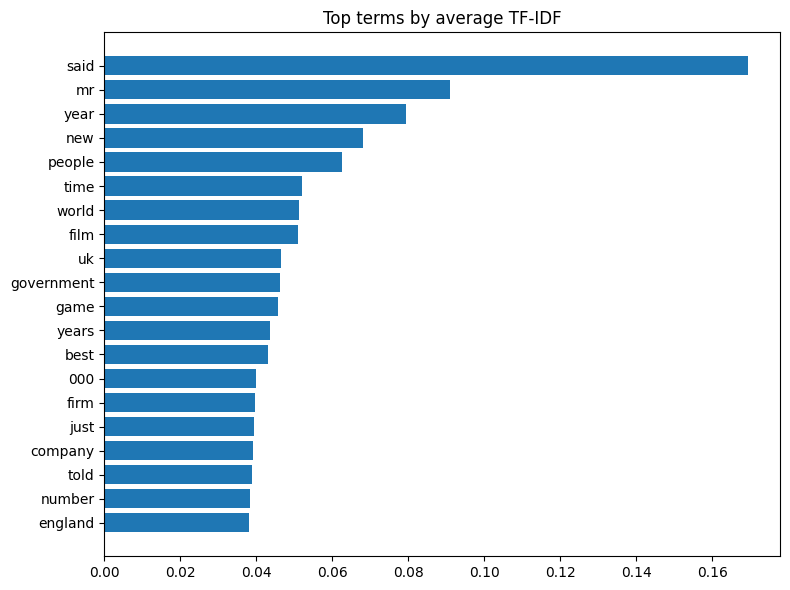

In [ ]:
# Create array of feature names
vocabulary = np.array(vectorizer.get_feature_names_out())

# Find the mean tf-idf score for each feature name across all 1,440 documents
avg_tfidf = X_train_tfidf.mean(axis=0).A1

# Find the top 20 terms
topk = 20
idx = np.argpartition(avg_tfidf, -topk)[-topk:]

# Plot the top terms
plt.figure(figsize=(8,6))
plt.barh(vocabulary[idx], avg_tfidf[idx])
plt.title('Top terms by average TF-IDF')
plt.tight_layout()

# Modeling

When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
> You should not include texts from the test dataset when training an unsupervised matrix factorization model. The whole point of a test set is to simulate unseen data, so leaking its word features into the factorization step contaminates evaluation. If the test data is mixed in during training, the model has already “peeked” at the distribution of terms and topics it’s supposed to be judged on, which inflates performance and kills the validity of your results. Keep the test set strictly out of the training input matrix, then transform it later with the factors learned from the training data.

### Apply Non-Negative Matrix Factorization to the Training Set

In [58]:
# Apply Non-Negative Matrix Factorization to discover topics
nmf = NMF(
    n_components = 5,
    init='nndsvda',
    random_state=42,
    max_iter=400,
    alpha_W=0.0,
    l1_ratio=0.0
)
W_train = nmf.fit_transform(X_train_tfidf)

# Print the topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f'Topic {topic_idx}: {[feature_names[i] for i in topic.argsort()[:-10:-1]]}')

Topic 0: ['people', 'said', 'music', 'technology', 'use', 'new', 'net', 'mobile', 'service']
Topic 1: ['game', 'england', 'win', 'play', 'players', 'team', 'time', 'games', 'half']
Topic 2: ['film', 'best', 'director', 'won', 'tv', 'year', 'british', 'million', 'uk']
Topic 3: ['mr', 'labour', 'blair', 'election', 'said', 'government', 'party', 'minister', 'brown']
Topic 4: ['said', 'year', 'company', 'firm', 'market', '2004', 'growth', 'sales', 'economy']


### Train a Classifier on the NMF Features

Training accuracy: 0.766
Classification report:
                precision    recall  f1-score   support

     business       0.70      0.86      0.77       335
entertainment       0.95      0.54      0.69       263
     politics       0.79      0.79      0.79       266
        sport       0.82      0.92      0.87       342
         tech       0.65      0.62      0.63       234

     accuracy                           0.77      1440
    macro avg       0.78      0.75      0.75      1440
 weighted avg       0.78      0.77      0.76      1440



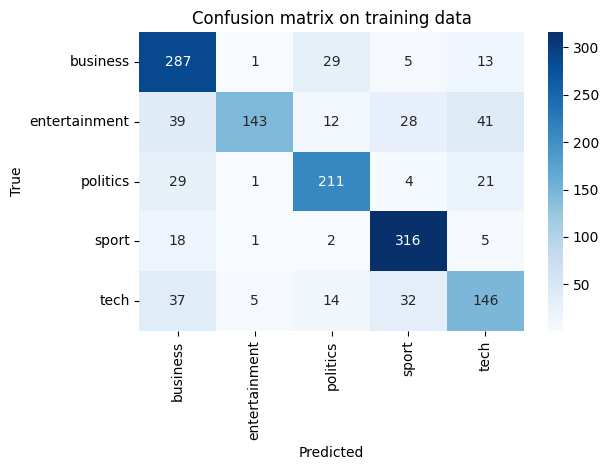

In [ ]:
# Create Logistic Regression Model
clf = LogisticRegression(max_iter=2000, C=1.0, solver='lbfgs')
clf.fit(W_train, y_train)

# Predict the training labels and compute metrics
y_train_pred = clf.predict(W_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_conf_mat = confusion_matrix(y_train, y_train_pred, labels=clf.classes_)

# Display the classification_report and confusion matrix
print(f'Training accuracy: {train_acc:.3f}')
print('Classification report:\n', classification_report(y_train, y_train_pred))
sns.heatmap(train_conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion matrix on training data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Create the NMF Test Solution Dataframe (for submission to Kaggle)

In [60]:
# Apply NMF to the test data
W_test = nmf.transform(X_test_tfidf)

# Predict the training labels and compute metrics
y_test_pred = clf.predict(W_test)

# Create a copy of the test_df
test_solution_df = test_df.copy()

# Add the predicted category to the test_df
test_solution_df['Category'] = y_test_pred

# Create a new test_solution_df that will be used to submit to Kaggle
test_solution_df = test_solution_df.loc[:,['ArticleId','Category']]

# Export test_solution_df to csv
test_solution_df.to_csv('./test_solution_df.csv', index=False)

> After submitting to Kaggle I got an accuracy of **76.1%** for the test dataset.

![test_solution_df](test_solution_df.png)

### Hyperparameters Grid Search
> I'm going to do a basic grid search by adjusting the following hyperparameters:
> - `max_features` in `TfidfVectorizer`
> - `C` value in `LogisticRegression`

In [61]:
# Define a function to build a pipeline to adjust the hyper‑parameters 
def build_pipeline(n_features=100, C=1.0):
    return Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=n_features)),
        ('nmf', NMF(n_components=5, max_iter=2000, random_state=42)),
        ('clf', LogisticRegression(max_iter=2000, C=C, solver='lbfgs'))
    ])

# Define the hyperparameter grid to test using GridSearchCV
param_grid = {
    'tfidf__max_features': [10, 100, 1000, 10000, 100000, 1000000],
    'clf__C': [0.01, 0.1, 1, 10, 100, 1000],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(build_pipeline(), param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=100,
                                                        stop_words='english')),
                                       ('nmf',
                                        NMF(max_iter=2000, n_components=5,
                                            random_state=42)),
                                       ('clf',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'tfidf__max_features': [10, 100, 1000, 10000, 100000,
                                                 1000000]})

### Grid Search Results

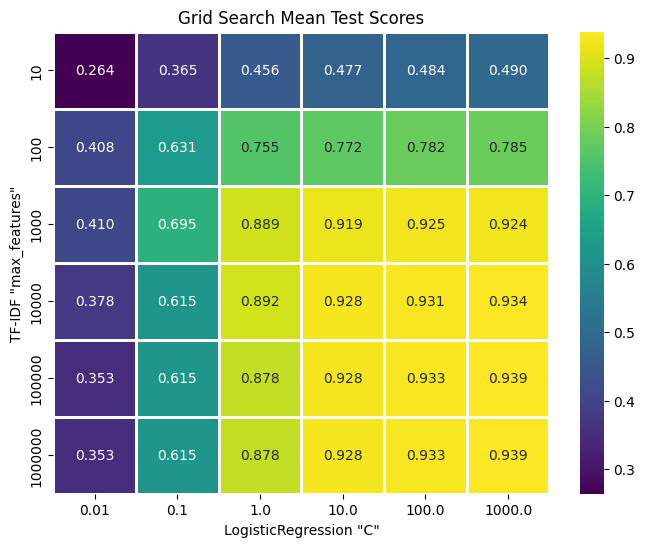

In [ ]:
# Create a dataframe of the grid_search.cv_results_
grid_search_cv_results = pd.DataFrame(grid_search.cv_results_)

# Pivot to get matrix form: rows = max_features, cols = C
grid_search_cv_heatmap_data = grid_search_cv_results.pivot_table(
    index='param_tfidf__max_features',
    columns='param_clf__C',
    values='mean_test_score'
)

# Display a heatmap of the grid_search.cv_results_
plt.figure(figsize=(8,6))
sns.heatmap(grid_search_cv_heatmap_data, annot=True, fmt='.3f', cmap='viridis', linewidths=1)
plt.title('Grid Search Mean Test Scores')
plt.ylabel('TF-IDF 'max_features'')
plt.xlabel('LogisticRegression 'C'')
plt.show()

In [63]:
# Display the best hyperparameter values for the given param_grid
grid_search.best_params_

{'clf__C': 1000, 'tfidf__max_features': 100000}

### Create a Best Test Solution Dataframe (for submission to Kaggle)

- The best test solution uses the optimal hyperparameters found using grid search.

In [64]:
# Get the best estimators
best_model = grid_search.best_estimator_

# Predict using the best estimators
y_test_best_pred = best_model.predict(X_test)

# Create a copy of the test_df
best_test_solution_df = test_df.copy()

# Add the predicted category to the test_df
best_test_solution_df['Category'] = y_test_best_pred

# Create another test_solution_df that will be used to submit to Kaggle
best_test_solution_df = best_test_solution_df.loc[:,['ArticleId','Category']]

# Export test_solution_df to csv
best_test_solution_df.to_csv('./best_test_solution_df.csv', index=False)

> Using the best estimators and submitting to Kaggle I got an much improved accuracy of **94.6%** for the test dataset.

![best_test_solution_df](best_test_solution_df.png)

### Build an Ensemble Classifer

In [ ]:
# Preprocess + ensemble
preprocess = [
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nmf', NMF(n_components=5, init='nndsvda', max_iter=400, random_state=42, solver='mu'))
]

# Define the Logistic Regression Base Classifier
logreg = LogisticRegression(max_iter=2000, solver='lbfgs', C=1.0, random_state=42)

# Define the Linear SVC Base Classifier
linsvc = CalibratedClassifierCV(
    estimator=LinearSVC(C=1.0, random_state=42),
    cv=3,
    method='sigmoid'
)

# Define the Random Forest Base Classifier
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

# Define the Gradient Boosting Base Classifier
gboost = GradientBoostingClassifier(random_state=42)

# Create the voting ensemble
voter = VotingClassifier(
    estimators=[
        ('lr', logreg),
        ('svm', linsvc),
        ('rf', rf),
        ('gb', gboost)
    ],
    voting='soft',
    weights=[1, 1, 1, 1],
    n_jobs=None
)

# Create a pipeline instance
pipeline = Pipeline(steps=preprocess + [('ensemble', voter)])

# Define the hyper-parameter grid
param_grid = {
    'tfidf__max_features': [1000, 5000, 20000],
    'ensemble__weights': [(1,1,1,1), (2,1,1,1), (1,2,1,1), (1,1,2,1), (1,1,1,2)],

    # Correct path for the calibrated LinearSVC
    'ensemble__svm__estimator__C': [0.5, 1.0, 2.0],

    # Other members
    'ensemble__lr__C': [0.5, 1.0, 2.0],
    'ensemble__rf__n_estimators': [200, 400],
    'ensemble__gb__learning_rate': [0.05, 0.1]
}

# Apply a grid search
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the ensemble model
search.fit(X_train, y_train)

# Predict with the best ensemble
y_ensemble_pred = search.predict(X_test)

print('Best params:', search.best_params_)
print('Best CV score:', search.best_score_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


Best params: {'ensemble__gb__learning_rate': 0.05, 'ensemble__lr__C': 1.0, 'ensemble__rf__n_estimators': 400, 'ensemble__svm__estimator__C': 1.0, 'ensemble__weights': (2, 1, 1, 1), 'tfidf__max_features': 20000}
Best CV score: 0.9465277777777779


### Create an Ensemble Test Solution Dataframe (for submission to Kaggle)

In [33]:
# Create a copy of the test_df
ensemble_test_solution_df = test_df.copy()

# Add the predicted category to the test_df
ensemble_test_solution_df['Category'] = y_ensemble_pred

# Create another test_solution_df that will be used to submit to Kaggle
ensemble_test_solution_df = ensemble_test_solution_df.loc[:,['ArticleId','Category']]

# Export test_solution_df to csv
ensemble_test_solution_df.to_csv('./ensemble_test_solution_df.csv', index=False)

> Using an ensemble and submitting to Kaggle I got an slight improvement with an accuracy of **95.0%** for the test dataset.

![ensemble_test_solution_df](ensemble_test_solution_df.png)

# Compare to Supervised Learning

### Split the Training Set into a Train and Validation Set

In [115]:
# Split out features and labels
X = train_df['Text']
y = train_df['Category']

# Hold out part of the training set for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline: TF-IDF + Logistic Regression
supervised_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
])

### Train the Supervised Model and Evaluate on the Training Set

Supervised Classification Report (train set):
                precision    recall  f1-score   support

     business       1.00      1.00      1.00       268
entertainment       1.00      1.00      1.00       210
     politics       1.00      1.00      1.00       213
        sport       1.00      1.00      1.00       274
         tech       0.99      0.99      0.99       187

     accuracy                           1.00      1152
    macro avg       1.00      1.00      1.00      1152
 weighted avg       1.00      1.00      1.00      1152



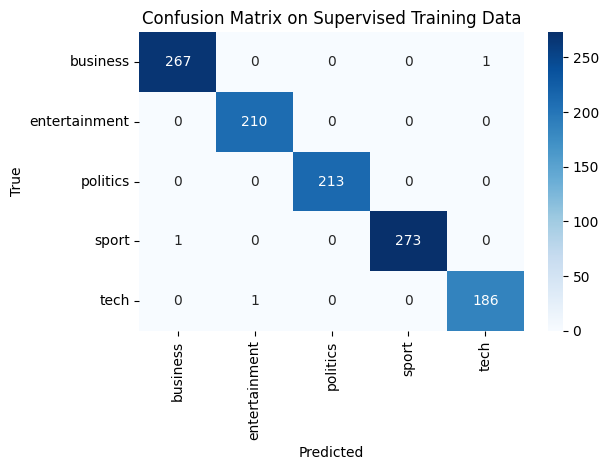

In [116]:
# Train supervised model
supervised_pipeline.fit(X_train, y_train)

# Evaluate on train split
y_pred_train = supervised_pipeline.predict(X_train)
print('Supervised Classification Report (train set):\n', classification_report(y_train, y_pred_train))
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix on Supervised Training Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Evaluate on the Supervised Validation Set

Supervised Classification Report (validation set):
                precision    recall  f1-score   support

     business       0.92      0.97      0.94        67
entertainment       1.00      0.98      0.99        53
     politics       0.98      0.96      0.97        53
        sport       0.93      1.00      0.96        68
         tech       0.97      0.83      0.90        47

     accuracy                           0.95       288
    macro avg       0.96      0.95      0.95       288
 weighted avg       0.96      0.95      0.95       288



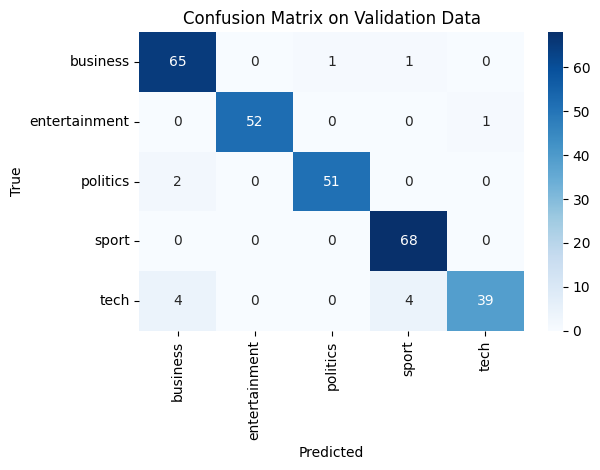

In [109]:
# Evaluate on validation split
y_pred_val = supervised_pipeline.predict(X_val)
print('Supervised Classification Report (validation set):\n', classification_report(y_val, y_pred_val))
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix on Validation Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Create an Supervised Test Solution Dataframe (for submission to Kaggle)

In [107]:
# Predict categories test_df
y_supervised_pred = supervised_pipeline.predict(X_test)

# Create a copy of the test_df
supervised_test_solution_df = test_df.copy()

# Add the predicted category to the test_df
supervised_test_solution_df['Category'] = y_supervised_pred

# Create another test_solution_df that will be used to submit to Kaggle
supervised_test_solution_df = supervised_test_solution_df.loc[:,['ArticleId','Category']]

# Export test_solution_df to csv
supervised_test_solution_df.to_csv('./supervised_test_solution_df.csv', index=False)

> Using a supervised model and submitting to Kaggle I got an higher accuracy of **97.7%** for the test dataset.

![supervised_test_solution_df](supervised_test_solution_df.png)

### Changing the Training Set Size

In [117]:
# Define the 
X = train_df['Text']
y = train_df['Category']

# Train-Validation Split
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

train_scores = []
val_scores = []

for frac in fractions:
    # Subsample training data
    X_sub, _, y_sub, _ = train_test_split(X_train_full, y_train_full,train_size=frac, random_state=42, stratify=y_train_full)
    
    # Pipeline: TF-IDF + Logistic Regression
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),
        ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
    ])
    
    pipeline.fit(X_sub, y_sub)
    
    # Accuracy on training subset
    train_acc = accuracy_score(y_sub, pipeline.predict(X_sub))
    train_scores.append(train_acc)
    
    # Accuracy on fixed validation set
    val_acc = accuracy_score(y_val, pipeline.predict(X_val))
    val_scores.append(val_acc)

### Plot the Supervised Learning Curve

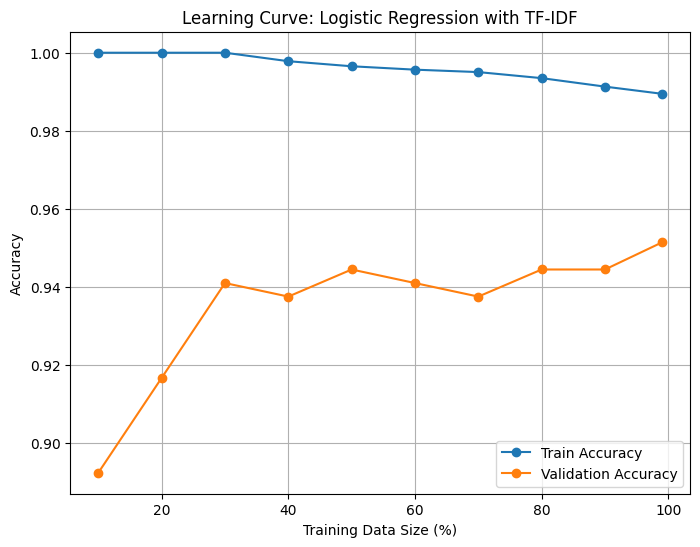

In [ ]:
# Plot learning curve
plt.figure(figsize=(8,6))
plt.plot([int(f*100) for f in fractions], train_scores, marker='o', label='Train Accuracy')
plt.plot([int(f*100) for f in fractions], val_scores, marker='o', label='Validation Accuracy')
plt.xlabel('Training Data Size (%)')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Logistic Regression with TF-IDF')
plt.legend()
plt.grid(True)
plt.show()

### Answering Part 1, Step 3, #2 Questions

Discuss comparison with the unsupervised approach.
>Supervised models, such as TF-IDF combined with logistic regression or ensembles, generally outperform unsupervised approaches like NMF or clustering. The supervised method benefits from having labeled examples to directly optimize classification boundaries, while the unsupervised approach only discovers latent structures without guidance, often leading to less accurate categorization.

Which methods are data-efficient (require a smaller amount of data to achieve similar results)?
> Supervised methods tend to be more data-efficient because even with a modest number of labeled samples, they can learn clear decision boundaries. Unsupervised methods usually require much larger datasets to extract stable latent topics, and even then, the topics might not align neatly with the target categories.

What about overfitting?
> Complex supervised models (like ensembles with deep trees or very flexible classifiers) are more prone to overfitting, especially if the training data is limited. They can memorize noise in the data, leading to inflated training scores but weaker generalization. Simpler models like logistic regression with regularization resist overfitting better, whereas unsupervised NMF usually underfits rather than overfits, because it does not tailor itself to the labels.

# Movie Ratings NMF

In [ ]:
train_df = pd.read_csv('./movies_train.csv')
test_df = pd.read_csv('./movies_test.csv')

# Encode user and movie IDs to indices
user_mapping = {u: i for i, u in enumerate(train_df['uID'].unique())}
movie_mapping = {m: i for i, m in enumerate(train_df['mID'].unique())}

n_users = len(user_mapping)
n_movies = len(movie_mapping)

# Build sparse user-item matrix
rows = train_df['uID'].map(user_mapping)
cols = train_df['mID'].map(movie_mapping)
ratings = train_df['rating'].astype(float)
user_item_sparse = csr_matrix((ratings, (rows, cols)), shape=(n_users, n_movies))

# Fit NMF on sparse matrix
nmf_model = NMF(n_components=20, init='nndsvda', random_state=42, max_iter=1000)
W = nmf_model.fit_transform(user_item_sparse)
H = nmf_model.components_

# Predictions
pred_matrix = np.dot(W, H)

# Evaluate RMSE on test data
y_true, y_pred = [], []
for _, row in test_df.iterrows():
    user, movie, actual = row['uID'], row['mID'], row['rating']
    if user in user_mapping and movie in movie_mapping:
        y_true.append(actual)
        y_pred.append(pred_matrix[user_mapping[user], movie_mapping[movie]])

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

np.float64(2.860485897304819)

 Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?
 > The RMSE of about 2.86 shows that sklearn’s NMF doesn’t perform very well for movie ratings because it treats missing values as zeros, ignores user or item biases, and struggles with the sparse nature of rating data. In contrast, simple baseline or similarity-based methods often do better because they directly use averages or nearest neighbors, which handle sparsity more naturally.  
 
 > To improve NMF results, you could add user and item bias terms, blend it with baseline predictions, tune the number of factors and regularization, or use recommender-specific tools like SVD or SVD++ that are designed for sparse rating prediction.